In [1]:
# %matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

## Funciones generales

In [2]:
#Da el espectro identificando los primeros máximos sin analizar
def Spectrum(datax,datay,intensity,num):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>intensity):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-num:i+num] )
                index_x.append( datax[i-num:i+num] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones


#Procesa el archivo txt de datos, inten se refiere a la intensidad mínima para buscar y num a la cantidad de puntos alrededor de la lorentziana
def DataProcess(l,inten,num):
    data = pd.read_csv(l, delimiter=' ')
    pixel = np.array(data['P'])
    intensidad = np.array(data['I'])

    marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad,inten,num)
    
    return pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones


#Retira aquellas líneas que no aparecen en el catálogo o no ayudan a la obtención de la lorentziana
def DataCatalogue(pixs,marker_x,marker_y, index_x,index_y,anotaciones):
    mar_x = []
    mar_y = []
    ind_y = []
    ind_x = []
    anot = []
   

    for i in range(0,len(marker_x)):
        if marker_x[i] not in pixs:
            mar_x.append(marker_x[i])
            mar_y.append(marker_y[i])
            ind_x.append(index_x[i])
            ind_y.append(index_y[i])
            anot.append(anotaciones[i])

    return mar_x,mar_y, ind_x,ind_y,anot


#Función Lorentziana
def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)


#Realiza el ajuste Lorentziano sobre el espectro catalogado
def AjusteLorentz(i,index_x, index_y):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y


#Devuelve el DataFrame con los píxeles calculados
def MakeDataFrame(rango,catalog_long,index_x, index_y):

    Datafit = pd.DataFrame()
    lineasfit = []
    alturafit = []

    for i in range(0,rango):
        linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x, index_y)
        lineasfit.append(linea)
        alturafit.append(altura)
    

    Datafit['Pixel'] = lineasfit
    Datafit['Intensidad'] = alturafit
    Datafit['Catalogo longitud'] = catalog_long

    return Datafit

#Obtener la regresion lineal
def LinearFit(datax,datay,n):
    param = np.polyfit(datax,datay, n)
    xm = np.linspace(min(datax),max(datax),len(datax))
    ym = np.polyval(param, xm)
    xres = datax
    ye = np.polyval(param, datax)
    res = ye - datay

    return ym,xm,res,xres,param

#Obtener la calibración de las lineas sospechosas
def LineasSus(pixs,param):
    Data = pd.DataFrame()
    Data['Pixel'] = pixs
    Orden1 = []
    Orden2 = []
    Orden3 = []
    for i in pixs:
        Orden1.append(np.polyval(param,i)*2)
        Orden2.append(np.polyval(param,i)) 
        Orden3.append(np.polyval(param,i)*(2/3)) 
    
    Data['Calibracion orden 1'] = Orden1
    Data['Calibracion orden 2'] = Orden2
    Data['Calibracion orden 3'] = Orden3

    return Data

#Convertir DataFrame a tabla de Latex
# print(DataFit_1.to_latex(index=False))

## Análisis

### Para intensidades grandes > 810

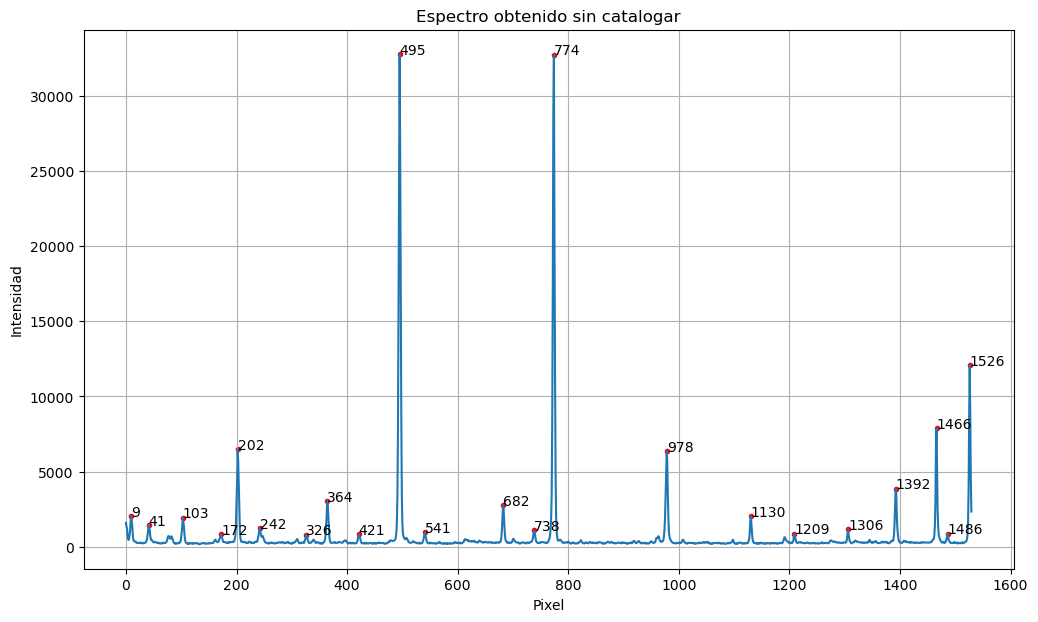

In [10]:
pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6520\th 6520 orden 2 spec.txt", 810, 7)

#Grafica
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x,marker_y,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))
#fig1.savefig('th 6200 orden 2 espectro tratado.jpg')

Aquellas líneas identificadas de la imagen 6565 del espectro fueron 302, 242, 169 a ser respectivamente 1526, 1466 y 1392, con longitudes de onda de  6556.33, 6554.16, 6551.70. Dos de ellas resultaron ser de orden superior, nuestra única referencia en el catálogo son 6554.16 y 6551.70. 

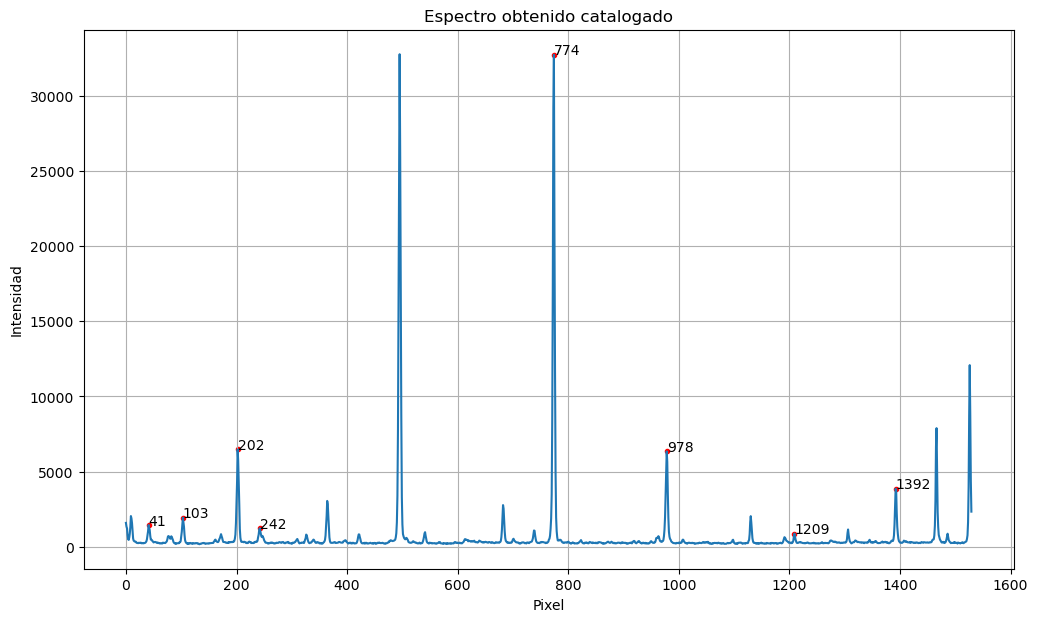

In [31]:
#Lista de pixeles que podrian ser de ordenes diferentes
PixSus_1 = [495,1526,1486,1306, 1130, 738, 682, 421,364,326, 172,9, 1466, 541]

#Se obtiene el espectro limpio
marker_x,marker_y, index_x,index_y,anotaciones = DataCatalogue(PixSus_1,marker_x,marker_y, index_x,index_y,anotaciones)
    
#Grafica
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_x,marker_y,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))
#fig2.savefig('th 6200 orden 2 espectro tratado.jpg')

In [32]:
#Longitudes de onda observadas en el catalogo, ingreso manual
catalog_long_1 = [6506.985, 6509.049, 6512.364, 6513.840, 6531.340, 6538.115, 6545.718 , 6551.705]
DataFit_1 = MakeDataFrame(len(marker_x),catalog_long_1,index_x, index_y)
DataFit_1

,Pixel,Intensidad,Catalogo longitud
0,41.513538,1372.650649,6506.985
1,103.223371,1912.553628,6509.049
2,202.413503,6644.932532,6512.364
3,242.544577,1090.204292,6513.840
4,773.671770,35027.450941,6531.340
5,978.089462,6591.805119,6538.115
6,1209.092861,779.132767,6545.718
7,1392.402248,4109.794971,6551.705


### Para líneas con intensidades pequeñas < 810

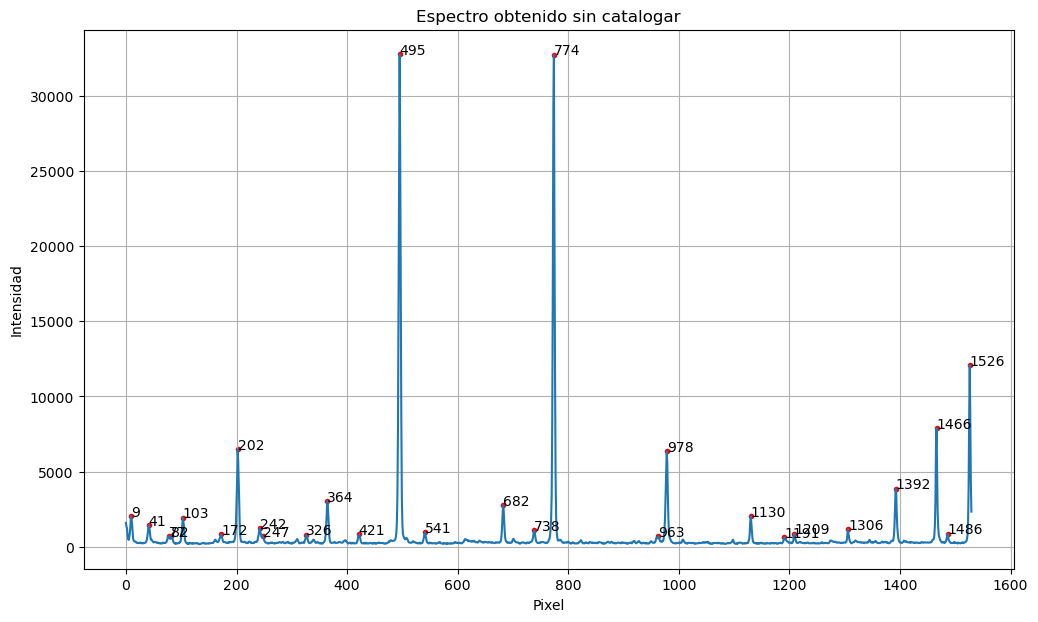

In [16]:
pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6520\th 6520 orden 2 spec.txt",610,18)

#Grafica
fig1_, ax1_ = plt.subplots(1,1, figsize=(12,7))
ax1_.plot(pixel_,intensidad_)
ax1_.scatter(marker_x_,marker_y_,marker='.',color = 'red')
ax1_.set_title('Espectro obtenido sin catalogar')
ax1_.set_xlabel('Pixel')
ax1_.set_ylabel('Intensidad')
ax1_.grid()
for i, label in enumerate(anotaciones_):
    plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))
#fig1_.savefig('th 6200 orden 2 espectro tratado.jpg')

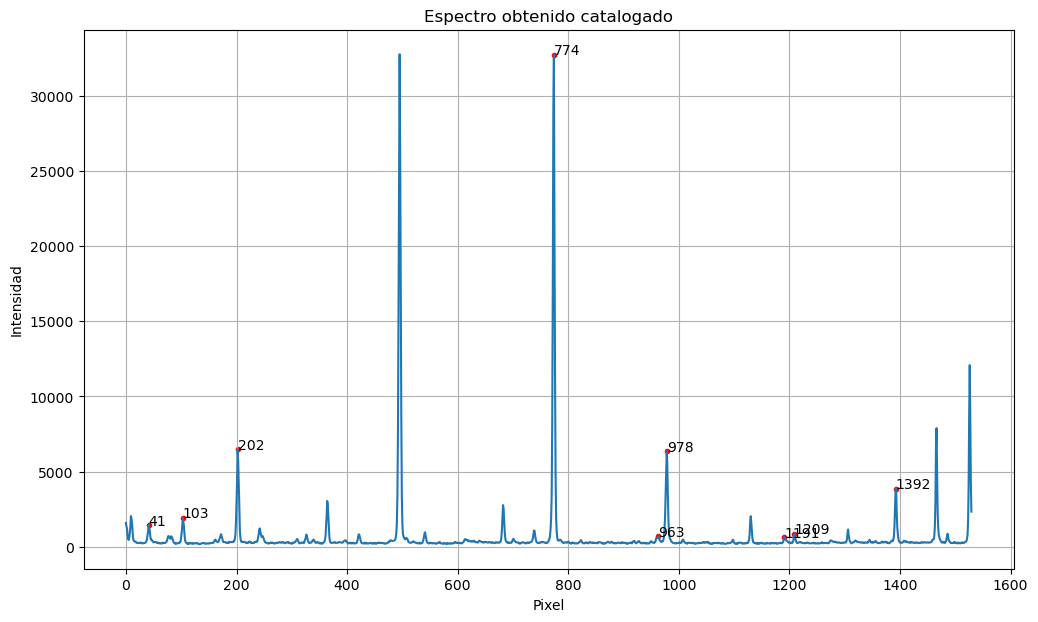

In [30]:
#Lista de pixeles que podrian ser de ordenes diferentes
PixSus_1 = [495,1526,1486,1306, 1130, 738, 682, 421,364,326, 172,9, 1466, 247, 82, 77, 242, 541]

#Se obtiene el espectro limpio
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(PixSus_1,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)
    
#Grafica
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_x_,marker_y_,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotaciones_):
    plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))
#fig2.savefig('th 6200 orden 2 espectro tratado.jpg')

In [22]:
#Longitudes de onda sospechosas de ser de diferente orden únicamente
PixSus_2 = [1191] 
PixSus_2

[1191]

#### Lineas para analizar individualmente

In [ ]:
# #NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
# pixsus = [] 

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt",275,10)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

# catalog_long_2 = []
# DataFit_21 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# DataFit_21

#### Lineas especiales

In [ ]:
# # Solo descomentar si es necesario un análisis con gráfica para ver el ajuste
# pixsus = [] #lineas ya analizadas

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt",275,18)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)


# def MakeDataFrame(rango,catalog_long,index_x_,index_y_):

#     Datafit = pd.DataFrame()
#     lineasfit = []
#     alturafit = []

#     for i in range(0,rango):
#         linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x_,index_y_)
#         lineasfit.append(linea)
#         alturafit.append(altura)
    

#     Datafit['Pixel'] = lineasfit
#     Datafit['Intensidad'] = alturafit
#     Datafit['Catalogo longitud'] = catalog_long

#     return Datafit, fity, fitx, x, y

# catalog_long_2 = []
# DataFit_2, fity, fitx, x, y = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(x,y)

### Unir todo en un dataframe

In [33]:
DataFit = DataFit_1
DataFit

,Pixel,Intensidad,Catalogo longitud
0,41.513538,1372.650649,6506.985
1,103.223371,1912.553628,6509.049
2,202.413503,6644.932532,6512.364
3,242.544577,1090.204292,6513.840
4,773.671770,35027.450941,6531.340
5,978.089462,6591.805119,6538.115
6,1209.092861,779.132767,6545.718
7,1392.402248,4109.794971,6551.705


### Regresión lineal de todos los puntos

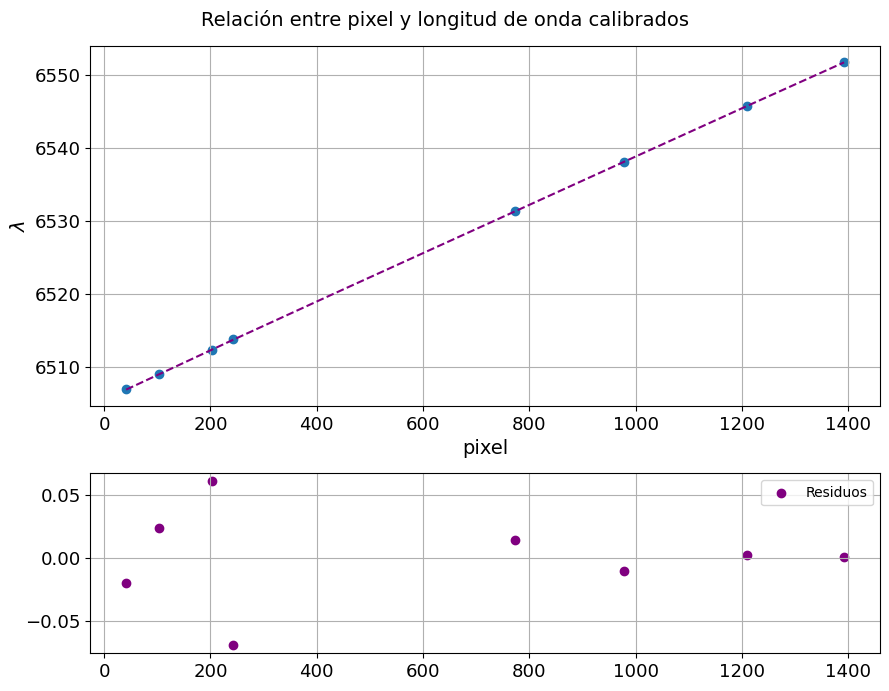

In [35]:
ym,_x,res,xres,param = LinearFit(DataFit_1['Pixel'],DataFit_1['Catalogo longitud'], 4) 

#Gráfico con residuos
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Relación entre pixel y longitud de onda calibrados',fontsize=14)

ax1.scatter(DataFit_1['Pixel'],DataFit_1['Catalogo longitud'])
ax1.plot(_x,ym,'--',color='purple')
ax1.set_ylabel(r"$\lambda$",fontsize=14)
ax1.set_xlabel(r'pixel',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(xres,res,label = 'Residuos',color='purple')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)
ax2.legend()
ax1.set_xlabel(r'pixel',fontsize=14)

fig1.tight_layout()
#fig1.savefig('DvsV.jpg')

### Análisis líneas sospechosas

In [36]:
# Por si se necesita quitar algun elemento None del dataframe .drop([2],axis=0).reset_index(drop=True)
LineasSos_1 = LineasSus(PixSus_1,param)
# LineasSos_1['Catalogo longitud'] = []
# LineasSos_1['Elemento'] = [ ]

# LineasSos_2 = LineasSus(PixSus_2,param)
# LineasSos_2['Catalogo longitud'] = []
# LineasSos_2['Elemento'] = []

# LineasSos = pd.concat([LineasSos_1,LineasSos_2], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)
# LineasSos['Longitud Calculada'] = []
# LineasSos

### Revisar residuos de lineas sospechosas

In [ ]:
# #Calcular residuos de las líneas sospechosas
# nist = LineasSos['Catalogo longitud']
# calc = LineasSos['Longitud Calculada']
# residuos = calc - nist

# pixel = LineasSos['Pixel']

# #Etiquetas de elementos
# label = [each for each in LineasSos['Elemento']]

# #Gráfico con residuos
# fig, ax = plt.subplots(1,1, figsize=(7,5))

# fig.suptitle(r'Residuos para líneas sospechosas',fontsize=14)

# ax.scatter(pixel,residuos,label = 'Residuos',color='purple')
# ax.grid()
# ax.legend()
# ax.set_xlabel(r'pixel',fontsize=14)
# ax.set_ylabel(r'armstrong',fontsize=14)

# for j in range (0, len(label)):
#     plt.annotate(label[j], (pixel[j], residuos[j]),fontsize=12)

# #fig1.savefig('DvsV.jpg')